In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import sys
sys.path.append("../")

In [4]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from CwnGraph import CwnBase
import seaborn as sns
import matplotlib.pyplot as plt

# Load Data

In [5]:
def load_synset_link_check():
    syn0 = pd.read_csv("../data/annot_sense_linkage/annot_sense_linkage_v1.csv")
    syn1 = pd.read_csv("../data/annot_sense_linkage/annot_sense_linkage_v1_Yolanda.csv")
    syn2 = pd.read_csv("../data/annot_sense_linkage/annot_sense_linkage_v2_Jessica.csv")
    syn3 = pd.read_csv("../data/annot_sense_linkage/annot_sense_linkage_v3_Joy.csv")
    syn1 = syn1[syn0.columns]
    syn2 = syn2[syn0.columns]
    syn3 = syn3[syn0.columns]
    syn = pd.concat([syn1, syn2, syn3])
    return syn

In [6]:
word_struct = pd.read_csv("../data/annot_word_struct/annot_word_struct_manual.csv", index_col=0)
syn_link = load_synset_link_check()

In [7]:
SENSE_LINK_FULL = "../data/model_sense_linkage/sense_link_full_data.pkl"
with open(SENSE_LINK_FULL, "rb") as fin:
    bert_links = pickle.load(fin)

In [8]:
syn_link.head()

,serial,lemma,c1,c2,hyper_resp,cwn_id_lemma,sense_def_lemma,cwn_id_c2,sense_def_c2,link_check,annot_cwn_id_lemma,annot_cwn_id_c2
0,0,一定,一,定,1,5052501,表對推論的肯定，沒有例外。,9254101,表對推論的肯定，沒有例外。,1.0,NaN,NaN
1,3,一點,一,點,1,3049101,表不確定的小數量。,4043813,表不確定的小數量。,1.0,NaN,NaN
2,6,並用,並,用,1,5082201,同時使用前述兩項事物。,4017401,利用特定對象的特定功能。,1.0,NaN,NaN
3,9,主持,主,持,1,6656901,主導並負責後述計畫。,6757405,維持擁有的狀態。,0.0,6656901.0,6757404.0
4,12,乃兄,乃,兄,1,5029001,代指聽話者的哥哥。,7042703,同輩而年紀比自己大的男子。,1.0,NaN,NaN


In [9]:
syn_link_m = syn_link[["lemma", "c1", "c2", "cwn_id_lemma", "cwn_id_c2", "link_check", "annot_cwn_id_lemma", "annot_cwn_id_c2"]]
word_struct_m = word_struct[["lemma", "struct"]]
syn_struct = syn_link_m.merge(word_struct_m, left_on="lemma", right_on="lemma", how="left")

In [10]:
syn_struct.groupby("struct").agg({"link_check": ["count", "mean"]})

link_check          
            count      mean
struct                     
NN            337  0.810089
NV            101  0.801980
VN            116  0.844828
VV            148  0.831081

## Synset linkage accuracy

In [11]:
print("Overall check: ", syn_struct.link_check.mean())
syn_struct_vn = syn_struct.loc[syn_struct.struct.apply(lambda x: x in ("NN", "VV")), :].copy()
print("NN/VV count: ", syn_struct_vn.shape[0] )
print("NN/VV check: ", syn_struct_vn["link_check"].mean())

Overall check:  0.8190883190883191
NN/VV count:  485
NN/VV check:  0.8164948453608247


# Error analysis

In [12]:
link_errors = syn_struct_vn.loc[syn_struct_vn.link_check == 0, :].copy()
print(link_errors.shape)
link_errors.dropna(inplace=True)
print(link_errors.shape)
link_errors = link_errors.astype({"annot_cwn_id_lemma": int, "annot_cwn_id_c2": int})

(89, 9)
(80, 9)


In [13]:
def make_bert_links_index(bert_data):
    bert_map = {}
    for x in bert_data:
        try:
            lemma_sense = x[0][0][0]
            lemma_id = lemma_sense.id[:-2]
            lemma = lemma_sense.lemmas[0]            
            bert_map[lemma.lemma] = x            
        except Exception as ex:
            print(ex)
            continue
    return bert_map
bert_map = make_bert_links_index(bert_links)

In [14]:
error_ranks = []
for idx, row in link_errors.iterrows():
    lemma = row.lemma
    sid1 = "{:08d}".format(row.annot_cwn_id_lemma)
    sid2 = "{:08d}".format(row.annot_cwn_id_c2)    
    lemma_id = sid1[:-2]
    links_x = bert_map.get(lemma)
    sid_pairs = [(sense_pair[0].id, sense_pair[1].id) for sense_pair, score in links_x]    
    try:
        pair_rank = sid_pairs.index((sid1, sid2))
    except:
        pair_rank = -1
    error_ranks.append((row.lemma, pair_rank))    

In [15]:
error_ranks_df = pd.DataFrame.from_records(error_ranks, columns=["lemma", "error_rank"])
syn_struct_vn = syn_struct_vn.merge(error_ranks_df, left_on="lemma", right_on="lemma", how="left")
syn_struct_vn.loc[syn_struct_vn["error_rank"].isnull(), "error_rank"] = 0

In [16]:
print("Rank < 5: ", syn_struct_vn[(syn_struct_vn.error_rank >= 0) & (syn_struct_vn.error_rank < 5)].shape[0] / syn_struct_vn.shape[0])
print("Rank < 10: ", syn_struct_vn[syn_struct_vn.error_rank >= 0].shape[0] / syn_struct_vn.shape[0])

Rank < 5:  0.9567010309278351
Rank < 10:  0.9814432989690721


## Make Baseline: random

In [17]:
cwn = CwnBase()

In [18]:
def count_senses(lemma):
    lemmas = cwn.find_lemma(f"^{lemma}$")
    n_senses = sum(len(x.senses) for x in lemmas)
    return n_senses

In [19]:
syn_struct_nsense = syn_struct_vn[["lemma", "c2"]].copy()

In [20]:
syn_struct_nsense["lemma_nsense"] = np.nan
syn_struct_nsense["c2_nsense"] = np.nan
syn_struct_nsense["rand_base"] = np.nan

In [21]:
syn_struct_nsense.head()

,lemma,c2,lemma_nsense,c2_nsense,rand_base
0,一點,點,NaN,NaN,NaN
1,並用,用,NaN,NaN,NaN
2,乃兄,兄,NaN,NaN,NaN
3,之後,後,NaN,NaN,NaN
4,亞洲,洲,NaN,NaN,NaN


In [22]:
for idx, row in tqdm(syn_struct_nsense.iterrows()):
    lemma_nsense = count_senses(row.lemma)
    c2_nsense = count_senses(row.c2)    
    rand_base = 1/(lemma_nsense * c2_nsense)
    syn_struct_nsense.loc[idx, "lemma_nsense"] = lemma_nsense
    syn_struct_nsense.loc[idx, "c2_nsense"] = c2_nsense
    syn_struct_nsense.loc[idx, "rand_base"] = rand_base

In [23]:
syn_struct_vn = syn_struct_vn.merge(syn_struct_nsense.drop("c2", axis=1), how="left", left_on="lemma", right_on="lemma")

In [24]:
syn_struct_vn.rand_base.mean()

0.14991622555317496

## Make baseline: first sense

In [25]:
is_first = []
for idx, row in syn_struct_vn.iterrows():
    if row.link_check == 1:
        if row.cwn_id_lemma % 10 == 1 and \
           row.cwn_id_c2 % 10 == 1:
            is_first.append(1)
        else:
            is_first.append(0)
    else:
        if row.annot_cwn_id_lemma % 10 == 1 and \
           row.annot_cwn_id_c2 % 10 == 1:
            is_first.append(1)
        else:
            is_first.append(0)

In [26]:
syn_struct_vn["is_first"] = is_first

In [27]:
print("Use first sense strategy: ", syn_struct_vn.is_first.mean())

Use first sense strategy:  0.41649484536082476


## Sense count and model errors

In [28]:
correct_lemma_nsense = syn_struct_vn.loc[syn_struct_vn.link_check==1, "lemma_nsense"]
error_lemma_nsense = syn_struct_vn.loc[syn_struct_vn.link_check==0, "lemma_nsense"]
correct_c2_nsense = syn_struct_vn.loc[syn_struct_vn.link_check==1, "c2_nsense"]
error_c2_nsense = syn_struct_vn.loc[syn_struct_vn.link_check==0, "c2_nsense"]

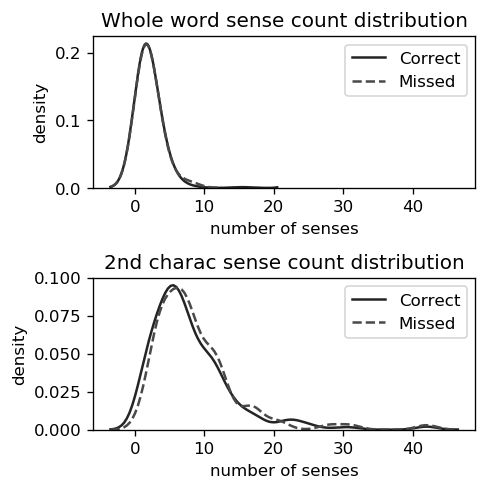

In [56]:
fig = plt.figure(figsize=(4,4), dpi=120)
ax1=plt.subplot(2,1,1)
BW = 1.5
sns.set_palette("gray")
sns.distplot(correct_lemma_nsense, hist=False, kde=True, kde_kws={'shade': False, "bw": BW}, label="Correct")
sns.distplot(error_lemma_nsense, hist=False, kde=True, kde_kws={'shade': False, "bw": BW, "linestyle": '--'}, label="Missed")
plt.title("Whole word sense count distribution")
plt.ylabel('density')
plt.xlabel('number of senses')

# C2 sense
plt.subplot(2,1,2,sharex=ax1)
sns.set_palette("gray")
sns.distplot(correct_c2_nsense, hist=False, kde=True, kde_kws={'shade': False, "bw": BW}, label="Correct")
sns.distplot(error_c2_nsense, hist=False, kde=True, kde_kws={'shade': False, "bw": BW, "linestyle": '--'}, label="Missed")
plt.title("2nd charac sense count distribution")
plt.ylabel('density')
plt.xlabel('number of senses')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.xlim(-0.1,0.8)

In [57]:
fig.savefig('../data/model_evaluation/sense_counts.png')

# Make Summarize Table

In [31]:
def in_rank_10(ranks):
    nom = sum(1 for x in ranks if x>=0)
    denom = len(ranks)
    return nom/denom

def in_rank_5(ranks):
    nom = sum(1 for x in ranks if 0<=x<5)
    denom = len(ranks)
    return nom/denom

summ_table = syn_struct_vn.groupby("struct").agg({
    "struct": "count", "link_check": "mean",
    "error_rank": [in_rank_5, in_rank_10],
    "rand_base": "mean", "is_first": "mean"})
summ_table = summ_table.transpose()

In [32]:
n_NN, n_VV = summ_table.iloc[0, :]
summ_table["overall"] = np.nan
summ_table.loc[summ_table.index[0], "overall"] = n_NN+n_VV
for idx, row in summ_table.iloc[1:, :].iterrows():
    summ_table.loc[idx, "overall"] = (row.NN*n_NN + row.VV*n_VV) / (n_NN+n_VV)

In [33]:
out_table = summ_table.copy()
out_table.index = summ_table.index.droplevel(1)

In [34]:
out_table = out_table.reset_index(drop=True)
row_names = ["N", "Accuracy", "First 5", "First 10", "Random", "Use First"]
out_table.rename(index={i: x for i, x in enumerate(row_names)}, inplace=True)

In [35]:
from tabulate import tabulate

In [36]:
print(tabulate(out_table, tablefmt='latex', floatfmt=".2f", headers=out_table.columns))

\begin{tabular}{lrrr}
\hline
           &     NN &     VV &   overall \\
\hline
 N         & 337.00 & 148.00 &    485.00 \\
 Accuracy  &   0.81 &   0.83 &      0.82 \\
 First 5   &   0.96 &   0.94 &      0.96 \\
 First 10  &   0.99 &   0.97 &      0.98 \\
 Random    &   0.12 &   0.21 &      0.15 \\
 Use First &   0.40 &   0.46 &      0.42 \\
\hline
\end{tabular}


In [37]:
out_table

struct,NN,VV,overall
N,337.000000,148.000000,485.000000
Accuracy,0.810089,0.831081,0.816495
First 5,0.964392,0.939189,0.956701
First 10,0.988131,0.966216,0.981443
Random,0.123285,0.210557,0.149916
Use First,0.397626,0.459459,0.416495
